In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers
import qiskit.quantum_info as qi

In [3]:
from kagome_trotter.circuits_1d_path import gate_path_conventional, gate_path_hybrid
from kagome_trotter.simulator_dm import compute_distance_trace_unitary_mod_phase
from kagome_trotter.hamiltonian import make_H_Heisenberg_path

In [4]:
num_qubits = 5
time_evolution = 2 * np.pi
num_steps_list = list(range(10,500,50))
print("trotter step list: ", num_steps_list)

trotter step list:  [10, 60, 110, 160, 210, 260, 310, 360, 410, 460]


In [5]:
H_Heisenberg = dict([("XXIII",1),
                     ("YYIII",1),
                     ("ZZIII",1),
                     ("IXXII",1),
                     ("IYYII",1),
                     ("IZZII",1),
                     ("IIXXI",1),
                     ("IIYYI",1),
                     ("IIZZI",1),
                     ("IIIXX",1),
                     ("IIIYY",1),
                     ("IIIZZ",1),])

In [6]:
# H_Heisenberg = make_H_Heisenberg_path(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
H = qi.SparsePauliOp.from_list(list(H_Heisenberg.items()))
print(H)
dm_H = H.to_matrix() ### same, np.allclose(dm_H, matrix_Heisenberg)
U = sp.linalg.expm(-1j * dm_H * time_evolution) ###! same, np.allclose(U, U_Heisenberg)

SparsePauliOp(['XXIII', 'YYIII', 'ZZIII', 'IXXII', 'IYYII', 'IZZII', 'IIXXI', 'IIYYI', 'IIZZI', 'IIIXX', 'IIIYY', 'IIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


In [7]:
dt = Parameter('dt')

fidelities_conventional = []
fidelities_hybrid = []

distances_trace_conventional = []
distances_trace_hybrid = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()

    matrix_path_qiskit = \
        qi.Operator(gate_path_conventional(num_qubits=num_qubits,
                                        num_steps=num_steps,
                                        dt=time_evolution / num_steps,
                                        type_block="3cnot",
                                        to_instruction=False,
                                        add_barrier=False,
                                       )
                   )# .data

    matrix_path_hybrid = \
        qi.Operator(gate_path_hybrid(num_qubits=num_qubits,
                                        num_steps=num_steps // 2, ###!
                                        dt=2 * time_evolution / num_steps, ###!
                                        type_H_eff="old",
                                        to_instruction=False,
                                        add_barrier=False,
                                       )
                   )# .data


    # operator_Hiesenberg = qi.Operator(U_Heisenberg.data)

    fidelities_conventional.append(qi.process_fidelity(matrix_path_qiskit, qi.Operator(U)))
    fidelities_hybrid.append(qi.process_fidelity(matrix_path_hybrid, qi.Operator(U)))

    distances_trace_conventional.append(compute_distance_trace_unitary_mod_phase(matrix_path_qiskit.data, qi.Operator(U).data))
    distances_trace_hybrid.append(compute_distance_trace_unitary_mod_phase(matrix_path_hybrid.data, qi.Operator(U).data))
    
    t2 = time.perf_counter()
    print('process fidelity between conventional and U_Heisenberg = {:.4f}'.format(fidelities_conventional[-1]))
    print('process fidelity between proposed and U_Heisenberg = {:.4f}'.format(fidelities_hybrid[-1]))
    print()
    print('trace norm between conventional and U_Heisenberg = {:.4f}'.format(distances_trace_conventional[-1]))
    print('trace norm between proposed and U_Heisenberg = {:.4f}'.format(distances_trace_hybrid[-1]))
    print("time:", t2 - t1)
    print()

trotter steps:  10
process fidelity between conventional and U_Heisenberg = 0.0140
process fidelity between proposed and U_Heisenberg = 0.0931

trace norm between conventional and U_Heisenberg = 18.6418
trace norm between proposed and U_Heisenberg = 14.6418
time: 0.019182374933734536

trotter steps:  60
process fidelity between conventional and U_Heisenberg = 0.9693
process fidelity between proposed and U_Heisenberg = 0.8045

trace norm between conventional and U_Heisenberg = 2.3350
trace norm between proposed and U_Heisenberg = 5.8452
time: 0.0968277920037508

trotter steps:  110
process fidelity between conventional and U_Heisenberg = 0.9924
process fidelity between proposed and U_Heisenberg = 0.9619

trace norm between conventional and U_Heisenberg = 1.1707
trace norm between proposed and U_Heisenberg = 2.5968
time: 0.17607145803049207

trotter steps:  160
process fidelity between conventional and U_Heisenberg = 0.9966
process fidelity between proposed and U_Heisenberg = 0.9845

tra

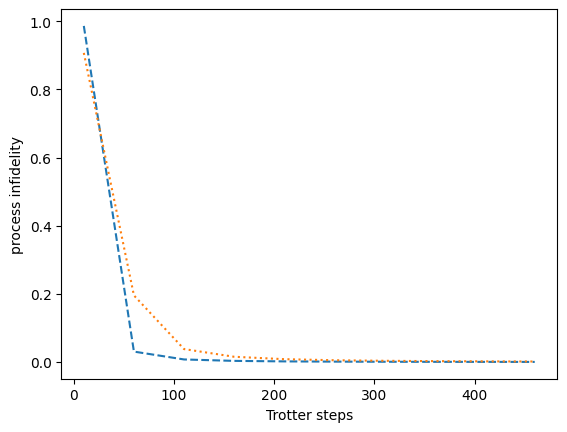

In [8]:
plt.plot(num_steps_list, 1 - np.array(fidelities_conventional), linestyle="dashed")
plt.plot(num_steps_list, 1 - np.array(fidelities_hybrid), linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("process infidelity")
# plt.yscale("log")
# plt.ylim(bottom=0,top=1)
plt.show()

In [9]:
fidelities_conventional

[0.014024292356079736,
 0.9693013276409241,
 0.9923616214554403,
 0.9965507263568952,
 0.998032995499321,
 0.9987278846349068,
 0.9991094969700297,
 0.9993416577126516,
 0.9994934396026536,
 0.999598127242681]

In [10]:
fidelities_hybrid

[0.09314516326558016,
 0.8045159371806326,
 0.9618895986417736,
 0.9844803847557035,
 0.991547946821145,
 0.9946623138816031,
 0.9963144912657556,
 0.9972986699910357,
 0.9979333408765194,
 0.9983669916356249]

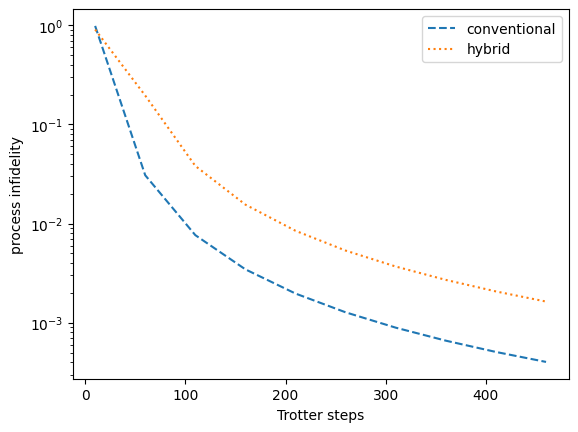

In [11]:
plt.clf()
p3, = plt.plot(num_steps_list, 1 - np.array(fidelities_conventional), linestyle="dashed")
p4, = plt.plot(num_steps_list, 1 - np.array(fidelities_hybrid), linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("process infidelity")
plt.yscale("log")
plt.legend([p3,p4],
           ["conventional","hybrid"])
plt.show()

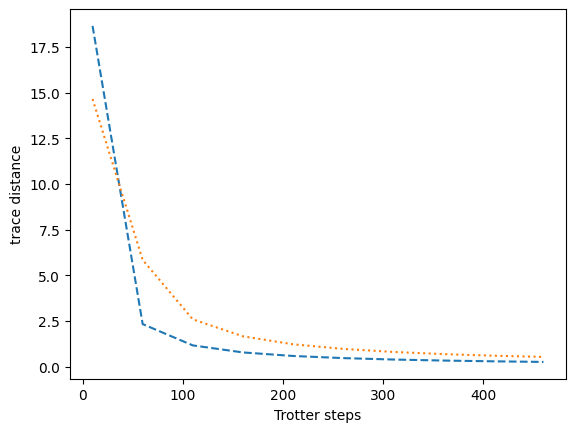

In [12]:
plt.plot(num_steps_list, distances_trace_conventional, linestyle="dashed")
plt.plot(num_steps_list, distances_trace_hybrid, linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("trace distance")
plt.show()

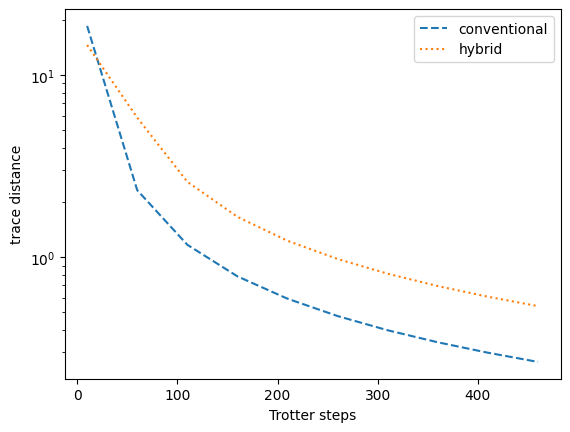

In [13]:
p3, = plt.plot(num_steps_list, distances_trace_conventional, linestyle="dashed")
p4, = plt.plot(num_steps_list, distances_trace_hybrid, linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("trace distance")
plt.yscale("log")
plt.legend([p3,p4],["conventional","hybrid"])
plt.show()

In [14]:
dt = Parameter('dt')

nums_cnot_conventional = []
nums_cnot_hybrid = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()

    qc_conventional = QuantumCircuit(num_qubits)
    qc_conventional.compose(gate_path_conventional(num_qubits=num_qubits,
                                                  num_steps=num_steps,
                                                  dt=time_evolution / num_steps,
                                                  type_block="3cnot",
                                                  to_instruction=False,
                                                  add_barrier=False,
                                                 ),
                           qubits=list(range(num_qubits)),
                           inplace=True,)
    # qc_conventional = qc_conventional.assign_parameters({dt: time_evolution / num_steps})
    qc_conventional_t3 = transpile(RemoveBarriers()(qc_conventional), 
                               optimization_level=3, 
                               basis_gates=["sx", "cx", "rz"])
    nums_cnot_conventional.append(qc_conventional_t3.count_ops().get("cx"))
    
    qc_hybrid = QuantumCircuit(num_qubits)
    qc_hybrid.compose(gate_path_hybrid(num_qubits=num_qubits,
                                          num_steps=num_steps // 2, ###!
                                          dt=2 * time_evolution / num_steps, ###!
                                          type_H_eff="old",
                                          to_instruction=False,
                                          add_barrier=False,
                                        ),
                       qubits=list(range(num_qubits)),
                       inplace=True,)
    # qc_hybrid = qc_hybrid.assign_parameters({dt: time_evolution / num_steps})
    qc_hybrid_t3 = transpile(RemoveBarriers()(qc_hybrid), 
                               optimization_level=3, 
                               basis_gates=["sx", "cx", "rz"])
    nums_cnot_hybrid.append(qc_hybrid_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print("number of CNOT gates in conventional:", nums_cnot_conventional[-1])
    print("number of CNOT gates in proposed:", nums_cnot_hybrid[-1])
    print("time:", t2 - t1)
    print()

trotter steps:  10
number of CNOT gates in conventional: 120
number of CNOT gates in proposed: 70
time: 0.6269302919972688

trotter steps:  60
number of CNOT gates in conventional: 720
number of CNOT gates in proposed: 420
time: 0.04078183392994106

trotter steps:  110
number of CNOT gates in conventional: 1320
number of CNOT gates in proposed: 770
time: 0.06464433297514915

trotter steps:  160
number of CNOT gates in conventional: 1920
number of CNOT gates in proposed: 1120
time: 0.08952266699634492

trotter steps:  210
number of CNOT gates in conventional: 2520
number of CNOT gates in proposed: 1470
time: 0.11417866707779467

trotter steps:  260
number of CNOT gates in conventional: 3120
number of CNOT gates in proposed: 1820
time: 0.13924795808270574

trotter steps:  310
number of CNOT gates in conventional: 3720
number of CNOT gates in proposed: 2170
time: 0.16895220801234245

trotter steps:  360
number of CNOT gates in conventional: 4320
number of CNOT gates in proposed: 2520
time

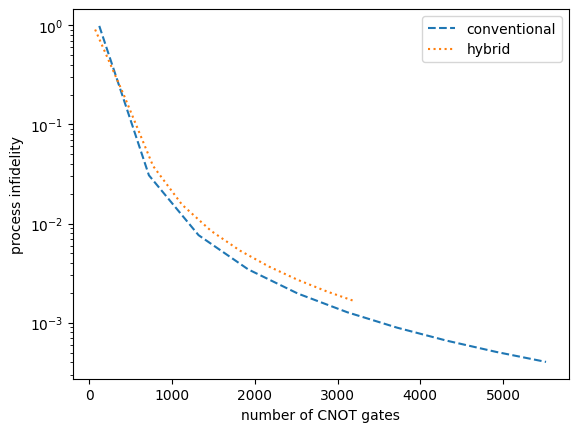

In [15]:
plt.clf()
p3, = plt.plot(nums_cnot_conventional, 1 - np.array(fidelities_conventional), linestyle="dashed")
p4, = plt.plot(nums_cnot_hybrid, 1 - np.array(fidelities_hybrid), linestyle="dotted")
plt.xlabel("number of CNOT gates")
plt.ylabel("process infidelity")
plt.yscale("log")
plt.legend([p3,p4],["conventional","hybrid"])
plt.show()